# Sparse Bayes Model

Let's model the data as arising from a generative model in which the log firing rates factorize.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [109]:
load_result = True

## Exploratory analysis

In [2]:
dat = pd.read_csv('data/prepared_data.csv')

In [3]:
dat.shape

(687276, 7)

In [4]:
dat.head(10)

,stim,unit,isfirst,isrewarded,count,trial,time
0,0,1068,0,0,4,57277,0
1,0,1069,0,0,1,57277,0
2,0,1070,0,0,6,57277,0
3,0,1071,0,0,0,57277,0
4,0,1072,1,0,3,60250,0
5,0,1073,1,0,1,60250,0
6,0,1074,1,0,3,60250,0
7,0,1075,0,0,2,61200,0
8,0,1076,0,0,1,61200,0
9,0,1077,0,0,1,66732,0


In [5]:
dat.groupby(['trial', 'unit']).count().sum()  # only one observation of each unit on each trial

stim          687276
isfirst       687276
isrewarded    687276
count         687276
time          687276
dtype: int64

# Subset data?

In [6]:
subset = False

if subset:
    sdat = dat[(dat.unit < 1100) & (dat.stim < 200)]
else:
    sdat = dat.copy()

In [7]:
mean_count = sdat.groupby(['stim', 'unit'])['count'].mean().unstack()
mean_count.head()

unit,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,5249,5250,5251,5252,5253,5254,5255,5256,5257,5258
stim,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.333333,0.000000,0.666667,0.333333,0.0,1.0,4.0,1.333333,4.666667,6.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.333333,2.666667,1.666667,1.0,1.0,5.0,1.000000,3.666667,3.666667
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.500000,0.000000,1.500000,0.500000,0.0,2.0,5.0,5.500000,2.500000,4.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.750000,1.000000,1.333333,0.333333,0.5,0.0,2.0,3.333333,4.000000,7.666667
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.400000,1.000000,1.333333,1.333333,0.0,2.0,2.0,1.666667,3.000000,6.000000


<IPython.core.display.Javascript object>


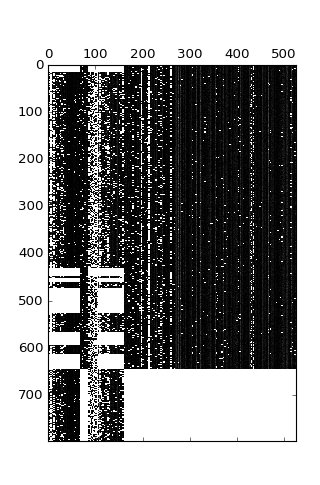

In [8]:
plt.matshow(mean_count, 'aspect=auto', cmap='gray')

In [11]:
S, U = mean_count.shape
N, _ = sdat.shape
print("stims: {}, units: {}, observations: {}".format(S, U, N))

stims: 798, units: 526, observations: 687276


# Set up Stan

In [12]:
import pystan
import pickle

In [13]:
K = 5  # number of possible features
unit = np.unique(sdat.unit.values, return_inverse=True)[1] + 1
stim = np.unique(sdat.stim.values, return_inverse=True)[1] + 1
spk_dat = {'count': sdat['count'], 'unit': unit, 'stim': stim, 'U': U, 'S': S, 'N': N, 'K': K}

In [14]:
def make_init_fun(U, S, K):
    # returns function that returns inits for model parameters
    # needed because Cauchy dists result in huge outliers
    return lambda: ({'b': 1 + 0.1 * np.random.randn(U),
                     'W_raw': np.abs(np.random.randn(S, K)/K),
                     'V_raw': np.random.randn(U, K)/K,
                     'phi_W': 1 + 0.01 * np.random.randn(S, K),
                     'phi_V': 1 + 0.01 * np.random.randn(U, K),
                     'delta_W': 1 + 0.01 * np.random.randn(K),
                     'delta_V': 1 + 0.01 * np.random.randn(K),
                    })

In [110]:
if not load_result:
    sm = pystan.StanModel(file='factor_bd.stan')

In [111]:
%%time
if not load_result:
    opt = sm.optimizing(data=spk_dat,
                        seed=12345,
                        iter=50000,
                        init=make_init_fun(U, S, K))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


In [112]:
if not load_result:
    fname = 'opt_values'
    with open('data/' + fname + '.stan_model', 'wb') as f:
        pickle.dump(opt, f)
else:
    fname = 'opt_values'
    with open('data/' + fname + '.stan_model', 'rb') as f:
        opt = pickle.load(f)    

<IPython.core.display.Javascript object>


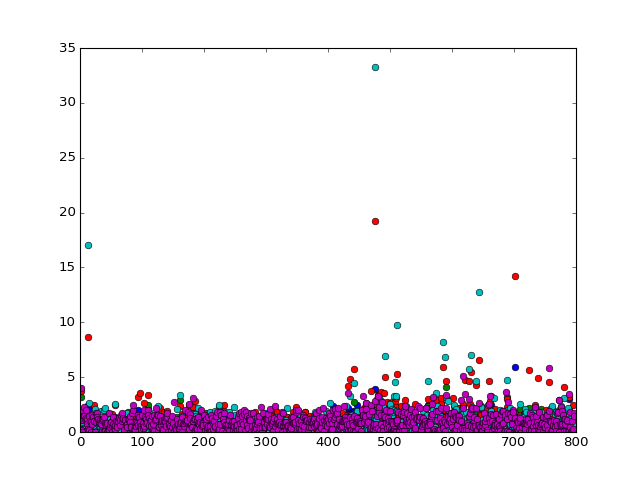

In [113]:
plt.figure()
plt.plot(opt['W'], 'o');

<IPython.core.display.Javascript object>


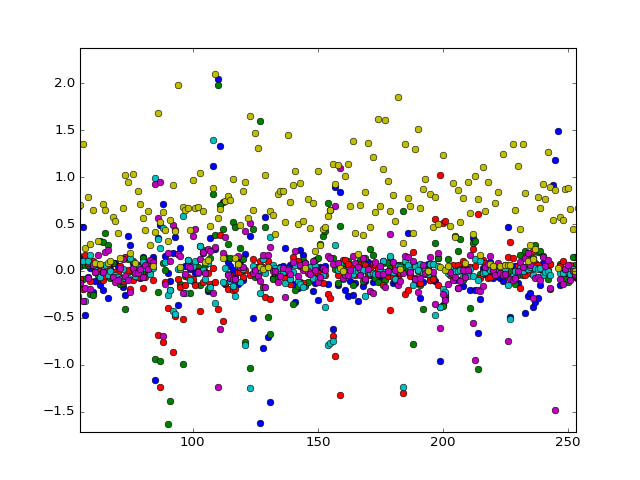

In [18]:
plt.figure()
plt.plot(opt['V'], 'o');

# Compare with image attributes

In [41]:
iminfo = pd.read_csv('data/iminfo798.csv').set_index('code')
iminfo.tail()

,image,monkey_name,Human?,Monkey face?,Object?,Perinea?,direct gaze?,averted gaze?,face oriented L,face oriented R,...,Male Perinea?,Female Perinea?,Cayo,Colony,head visible,tail visible,num legs,side view,frontal view,partially occuded
code,,,,,,,,,,,,,,,,,,,,,
1107,lum_tulip01.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1108,lum_tupperware05.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1109,lum_tweezers02b.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1110,lum_umbrella02a.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1111,lum_yarn.jpg,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
iminfo.columns

Index(['image', 'monkey_name', 'Human?', 'Monkey face?', 'Object?', 'Perinea?',
       'direct gaze?', 'averted gaze?', 'face oriented L', 'face oriented R',
       'face straight', 'threat?', 'scrambled?', 'Male Perinea?',
       'Female Perinea?', 'Cayo', 'Colony', 'head visible', 'tail visible',
       'num legs', 'side view', 'frontal view', 'partially occuded'],
      dtype='object')

In [106]:
chunks = []
for kk in range(K):
    for col in iminfo.columns[2:]:
        kcol = 'K' + str(kk)
        weighted_mean = np.average(iminfo_aug[col], weights=W[kcol])
        nat_mean = np.average(iminfo_aug[col])
        chunks.append({
                'content': col,
                'feature': kk,
                'natural': nat_mean,
                'weighted': weighted_mean,
                'ratio': weighted_mean/nat_mean,
                'change': weighted_mean/nat_mean - 1
            })
overlap = pd.DataFrame(chunks).sort_values(by=['feature', 'change'])

In [108]:
overlap.query('feature == 0')

,change,content,feature,natural,ratio,weighted
15,-0.459512,head visible,0,0.015038,0.540488,0.008128
7,-0.171756,face oriented R,0,0.112782,0.828244,0.093411
5,-0.135565,averted gaze?,0,0.250627,0.864435,0.216650
0,-0.107294,Human?,0,0.218045,0.892706,0.194650
8,-0.101643,face straight,0,0.134085,0.898357,0.120456
18,-0.083022,side view,0,0.026316,0.916978,0.024131
6,-0.082940,face oriented L,0,0.126566,0.917060,0.116069
4,-0.076751,direct gaze?,0,0.122807,0.923249,0.113381
17,-0.058985,num legs,0,0.184211,0.941015,0.173345
16,-0.026257,tail visible,0,0.078947,0.973743,0.076874


# Now sample from optimum

In [18]:
def make_sample_init_fun(U, S, K):
    # returns function that returns inits for model parameters
    # needed because Cauchy dists result in huge outliers
    return lambda: ({'b': opt['b'] * (1 + 0.01 * np.random.randn(U)),
                     'W_raw': opt['W_raw'] * (1 + 0.01 * np.random.randn(S, K)),
                     'V_raw': opt['V_raw'] * (1 + 0.01 * np.random.randn(U, K)),
                     'phi_W': opt['phi_W'] * (1 + 0.01 * np.random.randn(S, K)),
                     'phi_V': opt['phi_V'] * (1 + 0.01 * np.random.randn(U, K)),
                     'delta_W': opt['delta_W'] * (1 + 0.01 * np.random.randn(K)),
                     'delta_V': opt['delta_V'] * (1 + 0.01 * np.random.randn(K)),
                    })

In [19]:
%%time
fit = sm.sampling(data=spk_dat, iter=2000, thin=10, chains=4,
                  seed=12345,
                  pars=['W', 'V', 'b'],
                  init=make_sample_init_fun(U, S, K))

Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jmxp/anaconda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jmxp/

In [ ]:
def get_summ_df(fit, var):
    summ = fit.summary(var)
    return pd.DataFrame(summ['summary'], index=summ['summary_rownames'], columns=summ['summary_colnames'])

In [ ]:
W = get_summ_df(fit, 'W')

In [ ]:
W

In [ ]:
def plot_coeffs(df, sorted=False, transform=None):
    fig = plt.figure()
    if transform:
        b_m = transform(df['mean'])
        b_lo = b_m - transform(df['2.5%'])
        b_hi = transform(df['97.5%']) - b_m
    else:
        b_m = df['mean']
        b_lo = b_m - df['2.5%']
        b_hi = df['97.5%'] - b_m

    if len(b_m) > 1:
        if sorted:
            idx = np.argsort(b_m)
        else:
            idx = np.arange(len(b_m))

        b_m, b_lo, b_hi = b_m[idx], b_lo[idx], b_hi[idx]

        contains_1 = (df['2.5%'][idx] < 0) & (df['97.5%'][idx] > 0)
        
    else:
        contains_1 = (df['2.5%'] < 0) & (df['97.5%'] > 0)
    
    plt.errorbar(np.arange(len(b_m)), b_m, yerr=[b_lo, b_hi], capthick=0, 
                 marker='o', linestyle='None')

    # plot "significant" coefficients in red
    
    sigs = np.where(~contains_1)[0]
    plt.errorbar(sigs, b_m[sigs], yerr=[b_lo[sigs], b_hi[sigs]], capthick=0, 
                 marker='o', linestyle='None', color='red')

    if transform:
        plt.axhline(transform(0), color='k', zorder=-1)
    else:
        plt.axhline(0, color='k', zorder=-1)
            
    plt.xlim(-1, len(b_m) + 1)
    
    return fig

In [ ]:
plot_coeffs(W, sorted=True);
plt.ylim(-10, 10)

In [ ]:
wt = fit.extract('W', permuted=False)
plt.figure()
plt.plot(wt[:, 1:10, 0]);

In [ ]:
wt = fit.extract('W', permuted=False)
wt.shape

In [ ]:
V = get_summ_df(fit, 'V')
V

In [ ]:
plot_coeffs(V, sorted=True);
plt.ylim(-10, 10)

In [ ]:
baseline = get_summ_df(fit, 'b')
baseline

In [ ]:
plot_coeffs(baseline, sorted=True);